<a href="https://colab.research.google.com/github/akhil1198/RL-PA1/blob/main/RL_PA_1_Q_Learning_SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 12.8 MB/s eta 0:00:00


In [3]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

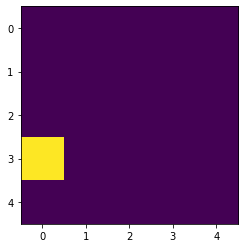

<IPython.core.display.Javascript object>

In [4]:
output_grid = widgets.Grid(1,1)

for _ in range(5):
  grid = np.zeros((5, 5))
  grid[np.random.randint(5), np.random.randint(5)] = 1

  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    plt.imshow(grid)
  time.sleep(2) 

Creating an Environment with all the actions, states, rewards and positions

In [169]:
from IPython.utils.path import random
class GridEnv(gym.Env):
  def __init__(self, env_type):
    self.environment_type = env_type
    self.environment_width = 5
    self.environment_height = 5
    self.observation_space = spaces.Discrete(25)
    self.action_space = spaces.Discrete(4)

    self.timestep = 0
    self.max_timesteps = 15

    self.agent_pos = [0, 0]
    self.goal_pos = [4, 4]

    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5

    self.reward = 0
    self.truncated = False
    self.terminated = False
    self.reward_pos = np.asarray([[0, 4], [2, 1], [3, 4], [4, 2]])
    self.negreward_pos = np.asarray([[1, 2], [3, 0], [3, 3]])

    #for stochastic env
    self.random_number = 0
    self.rand_action = 0

  def reset(self):
    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()

    return observation, self.agent_pos
  
  def step(self, action):
    # print("action", action)
    # action = int(action)
    if action == 0:
      #print("at 0 - > agent_pos[0] += 1")
      self.agent_pos[0] += 1
    if action == 1:
      #print("at 1 -> agent_pos[0] -= 1")
      self.agent_pos[0] -= 1
    if action == 2:
      #print("at 2 -> agent_pos[1] += 1")
      self.agent_pos[1] += 1
    if action == 3:
      #print("at 3 -> agent_pos[1] -= 1")
      self.agent_pos[1] -= 1
    #stochastic method
    if self.environment_type == "stochastic":
      self.random_number = np.random.rand()
      self.rand_action = np.random.randint(4)
      if self.random_number < 0.9:
        #print("Executing the right action -> ", action)
        if action == 0:
          #print("at 0 - > agent_pos[0] += 1")
          self.agent_pos[0] += 1
        if action == 1:
          #print("at 1 -> agent_pos[0] -= 1")
          self.agent_pos[0] -= 1
        if action == 2:
          #print("at 2 -> agent_pos[1] += 1")
          self.agent_pos[1] += 1
        if action == 3:
          #print("at 3 -> agent_pos[1] -= 1")
          self.agent_pos[1] -= 1
      elif self.random_number > 0.9:
        #print("Executing Random Action", self.rand_action)
        if self.rand_action == 0:
          self.agent_pos[0] += 1
        if self.rand_action == 1:
          self.agent_pos[0] -= 1
        if self.rand_action == 2:
          self.agent_pos[1] += 1
        if self.rand_action == 3:
          self.agent_pos[1] -= 1
      
    #print(self.agent_pos)
    #Comment this to demonstrate the truncation condition.
    self.agent_pos = np.clip(self.agent_pos, 0, 4)

    self.state = np.zeros((5,5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()

    self.reward = 0
    #[0, 4], [2, 1], [3, 4], [4, 2]
    if np.array_equal(self.agent_pos, self.reward_pos[0]):
      self.reward = self.reward + 2
    
    if np.array_equal(self.agent_pos, self.reward_pos[1]):
      self.reward = self.reward + 4
    
    if np.array_equal(self.agent_pos, self.reward_pos[2]):
      self.reward = self.reward + 8
    
    if np.array_equal(self.agent_pos, self.reward_pos[3]):
      self.reward = self.reward + 6
    

    if np.array_equal(self.agent_pos, self.goal_pos):
      self.reward += 10
    

    #[1, 2], [3, 0], [3, 3]
    if np.array_equal(self.agent_pos, self.negreward_pos[0]):
      self.reward = self.reward - 5
    
    if np.array_equal(self.agent_pos, self.negreward_pos[1]):
      self.reward = self.reward - 6
    
    if np.array_equal(self.agent_pos, self.negreward_pos[2]):
      self.reward = self.reward - 2

    self.timestep += 1

    #print("truncated -> ", self.agent_pos,)
    terminated = True if self.timestep >= self.max_timesteps else False
    truncated = True if np.all((self.agent_pos[0] >= 0) & (self.agent_pos[0] <= 4) & (self.agent_pos[1] >= 0) & (self.agent_pos[1] <= 4)) else False

    info = {}
    
    return observation, self.reward, terminated, truncated, info, self.agent_pos

  def render(self):
    print("Reward -> ", self.reward)
    plt.imshow(self.state)
    


Creating a Random Agent 

In [170]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
  def step(self, obs):
    return np.random.choice(self.action_space.n)
  

Starting the execution by calling all the methods in the Environment until termination of process

Deterministic Environment: 

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  0


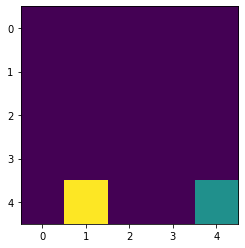

<IPython.core.display.Javascript object>

In [29]:
env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

while not terminated:
  action = agent.step(obs)
  #action = input()
  observation, reward, terminated, truncated, info, agent_pos = env.step(action)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)


************************************************************************
Stochastic Environment: 

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  0


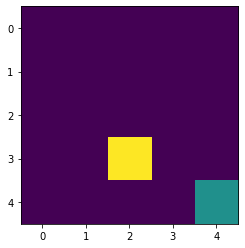

<IPython.core.display.Javascript object>

In [30]:
env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

while not terminated:
  action = agent.step(obs)
  #action = input()
  observation, reward, terminated, truncated, info, agent_pos = env.step(action)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)

-----------------------------------------------------------------------------
**Part - 2**

---


**Q-Learning for Deterministic Environment**

In [127]:
import random
from IPython.display import clear_output

env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

# Hyperparameters
alpha = 0.15
gamma = 0.93
epsilon = 1.0
epsilon_val = []
reward_val = []

num_episodes = 5000

# For plotting metrics
all_epochs = []
all_penalties = []

#Q-Table
q_table = np.random.rand(25, 4)
q_table = q_table.astype(int)

#running for 1000 episodes
for episode in range(num_episodes):
  #resetting the state 
  state, agent_pos = env.reset()
  epochs = 0
  penalties = 0

  index = 0
  state_to_list = state.tolist()
  if 1 in state_to_list:
    index = state_to_list.index(1)
  # print(index)
  
  for timestep in range(15):
    #Choosing an action based on e-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      action = np.argmax(q_table[index])

    # action = np.clip(action, 0, 3)
    observation, reward, terminated, truncated, info, new_agent_pos = env.step(action)

    new_state_to_list = observation.tolist()
    if 1 in new_state_to_list:
      index2 = new_state_to_list.index(1)

    q_table[index, action] = q_table[index, action] + alpha * (reward + gamma * np.max(q_table[index2]) - q_table[index, action])

    # if reward == -5 or reward == -6 or reward == -2:
    #   penalties += 1
    
    agent_pos = new_agent_pos
    epochs += 1
  reward_val.append(reward)
  epsilon *= 0.9990
  epsilon_val.append(epsilon)
  # print(epsilon)

# print("Q-Table : ", q_table)
# print(epsilon_val)


In [128]:
print(q_table)

[[47 46 48 42]
 [ 9  2  6  3]
 [ 1  7  2 11]
 [40 16 31 25]
 [48 25 24 25]
 [17  4 11  6]
 [ 7  1  6  2]
 [42 18 30 13]
 [40 22 35 24]
 [48 40 45 38]
 [35  4 24 20]
 [28 11 21 15]
 [39 14 40 32]
 [42 37 44 39]
 [48 42 43 40]
 [12  8 21  8]
 [31 17 29 19]
 [44 32 43 36]
 [47 46 48 40]
 [48 46 48 39]
 [42 32 48 37]
 [44 30 48 39]
 [46 41 47 40]
 [48 46 48 41]
 [ 0  0  0  0]]


**Epsilon-Decay Graph**

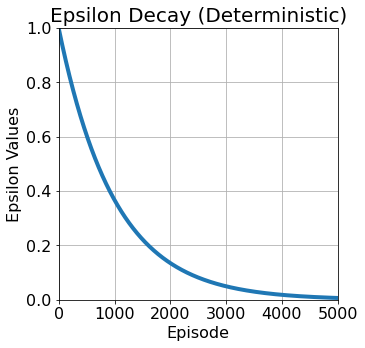

In [129]:
plt.figure(figsize=(5,5))
plt.plot(epsilon_val, linewidth=4)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Epsilon Values', fontsize=16)
plt.title('Epsilon Decay (Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()

**Total Rewards per episode**

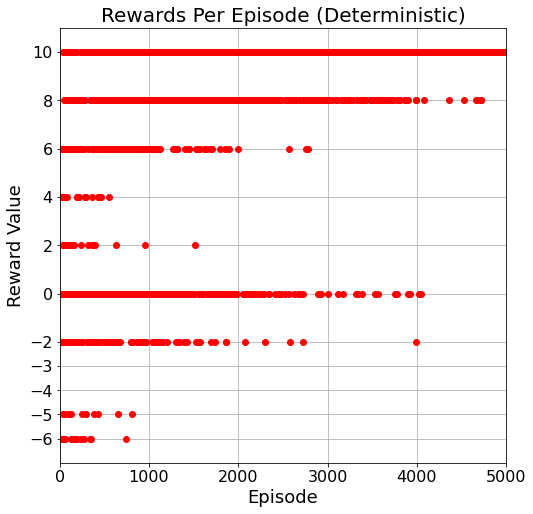

In [130]:
# print(reward_val)
plt.figure(figsize=(8,8))
plt.plot(reward_val, 'ro')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Reward Value', fontsize=18)
plt.title('Rewards Per Episode (Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-6, -5, -4, -3, -2, 0, 2, 4, 6, 8, 10], fontsize=16)
plt.ylim(ymin=-7, ymax=11)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()

**Q-Learning for Stochastic Environment**

In [171]:
import random
from IPython.display import clear_output

env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

# Hyperparameters
alpha = 0.15
gamma = 0.93
epsilon = 1.0
epsilon_val_stoc = []
reward_val_stoc = []

num_episodes = 5000

# For plotting metrics
all_epochs = []
all_penalties = []

#Q-Table
q_table_stoc = np.random.rand(25, 4)
q_table_stoc = q_table_stoc.astype(int)

#running for 1000 episodes
for episode in range(num_episodes):
  #resetting the state 
  state, agent_pos = env.reset()
  epochs = 0
  penalties = 0

  index 
  state_to_list = state.tolist()
  if 1 in state_to_list:
    index = state_to_list.index(1)
  # print(index)
  
  for timestep in range(15):
    #Choosing an action based on e-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      action = np.argmax(q_table_stoc[index])

    # action = np.clip(action, 0, 3)
    observation, reward, terminated, truncated, info, new_agent_pos = env.step(action)

    new_state_to_list = observation.tolist()
    if 1 in new_state_to_list:
      index2 = new_state_to_list.index(1)

    q_table_stoc[index, action] = q_table_stoc[index, action] + alpha * (reward + gamma * np.max(q_table_stoc[index2]) - q_table_stoc[index, action])

    # if reward == -5 or reward == -6 or reward == -2:
    #   penalties += 1
    
    agent_pos = new_agent_pos
    epochs += 1
  reward_val_stoc.append(reward)
  epsilon *= 0.9990
  epsilon_val_stoc.append(epsilon)
  # print(epsilon)

# print("Q-Table : ", q_table)
# print(epsilon_val)


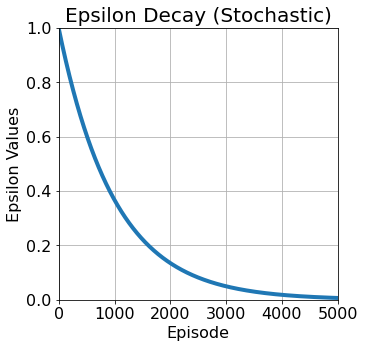

In [172]:
plt.figure(figsize=(5,5))
plt.plot(epsilon_val_stoc, linewidth=4)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Epsilon Values', fontsize=16)
plt.title('Epsilon Decay (Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()

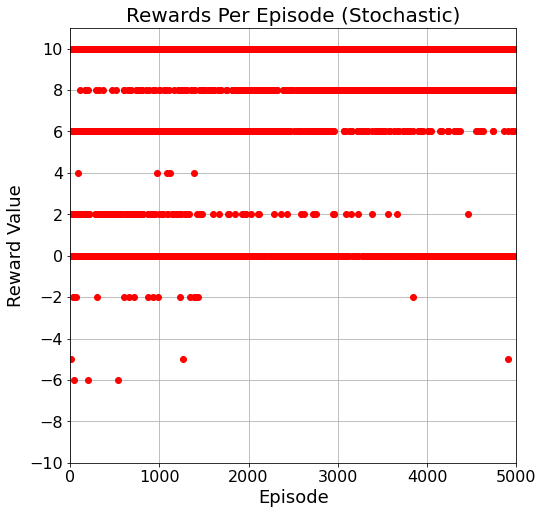

In [173]:
plt.figure(figsize=(8,8))
plt.plot(reward_val_stoc, 'ro')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Reward Value', fontsize=18)
plt.title('Rewards Per Episode (Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10], fontsize=16)
plt.ylim(ymin=-10, ymax=11)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()

In [174]:
# Write Q-table to pickle file
with open('q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)

# Download pickle file
from google.colab import files
files.download('q_table.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Testing Q-Values with 5x5 Grid Environment - Deterministic**

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  10


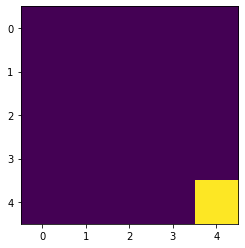

<IPython.core.display.Javascript object>

In [144]:
env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

def get_max_val(arg):
  return max(arg)
  
for i in q_table:
  max_val = get_max_val(i)
  i_to_list = i.tolist()
  max_index = i_to_list.index(max_val)
  observation, reward, terminated, truncated, info, agent_pos = env.step(max_index)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)

  

**Testing Q-Values with 5x5 Grid Environment - Stochastic**

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward ->  10


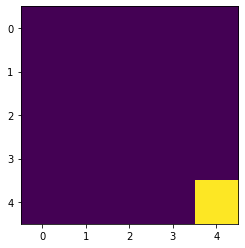

<IPython.core.display.Javascript object>

In [145]:
env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

obs, info = env.reset()
terminated, truncated = False, False

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

def get_max_val(arg):
  return max(arg)
  
for i in q_table_stoc:
  max_val = get_max_val(i)
  # print(type(i))
  i_to_list = i.tolist()
  max_index = i_to_list.index(max_val)
  # print(max_index)
  observation, reward, terminated, truncated, info, agent_pos = env.step(max_index)
  # observation, reward, terminated, truncated, info, agent_pos = env.step(action)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
    env.render()
  time.sleep(1)

  

In [ ]:
# plot cumulative avg rewards per episdoe 

**SARSA Implementation**

In [175]:
import random
from IPython.display import clear_output

env = GridEnv(env_type = "deterministic")
agent = RandomAgent(env)

# Hyperparameters
alpha = 0.12
gamma = 0.95
epsilon = 1.0
epsilon_sarsa = []
reward_sarsa = []

num_episodes = 5000
max_timesteps = 15

# For plotting metrics
all_epochs = []
all_penalties = []
state1 = 0
#Q-Table
q_table_sarsa = np.random.rand(25, 4)
q_table_sarsa = q_table_sarsa.astype(int)

#running for 1000 episodes
for episode in range(num_episodes):
  #resetting the state 
  state, agent_pos = env.reset()
  epochs = 0
  # penalties = 0

  # print(state)
  state_to_list = state.tolist()
  if 1 in state_to_list:
    state1 = state_to_list.index(1)
  # print(index)
  
  for timestep in range(max_timesteps):
    #Choosing an action based on e-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      action = np.argmax(q_table_sarsa[state1])

    #getting the next state, reward
    observation, reward, terminated, truncated, info, new_agent_pos = env.step(action)

    #getting the new state
    new_state_to_list = observation.tolist()
    if 1 in new_state_to_list:
      state2 = new_state_to_list.index(1)

    if np.random.rand() < epsilon:
      action2 = np.random.choice(env.action_space.n)
    else:
      action2 = np.argmax(q_table_sarsa[state2])

    q_table_sarsa[state1, action] = q_table_sarsa[state1, action] + alpha * (reward + gamma * (q_table_sarsa[state2, action2] - q_table_sarsa[state1, action]))

    # if reward == -5 or reward == -6 or reward == -2:
    #   penalties += 1
    
    # agent_pos = new_agent_pos
    epochs += 1
  reward_sarsa.append(reward)
  epsilon *= 0.9990
  epsilon_sarsa.append(epsilon)
  # print(epsilon)

# print("Q-Table : ", q_table_sarsa)
# print(epsilon_val)
# print("Q Table : ", q_table_sarsa)

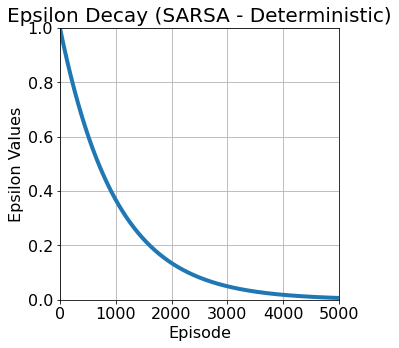

In [176]:
plt.figure(figsize=(5,5))
plt.plot(epsilon_sarsa, linewidth=4)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Epsilon Values', fontsize=16)
plt.title('Epsilon Decay (SARSA - Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()

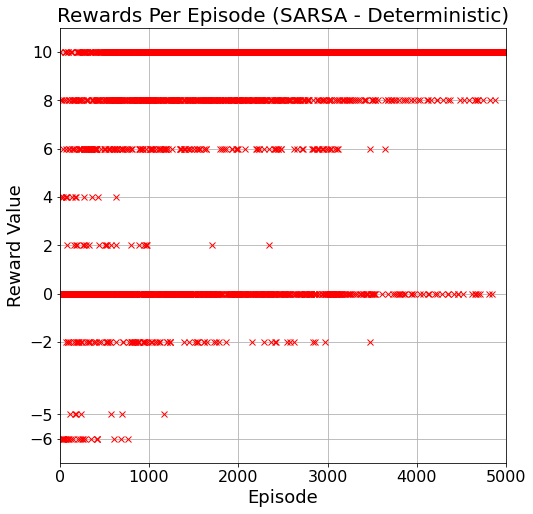

In [184]:
plt.figure(figsize=(8,8))
plt.plot(reward_sarsa, 'rx')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Reward Value', fontsize=18)
plt.title('Rewards Per Episode (SARSA - Deterministic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-6, -5, -2, 0, 2, 4, 6, 8, 10], fontsize=16)
plt.ylim(ymin=-7, ymax=11)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()

In [185]:
import random
from IPython.display import clear_output

env = GridEnv(env_type = "stochastic")
agent = RandomAgent(env)

# Hyperparameters
alpha = 0.12
gamma = 0.95
epsilon = 1.0
epsilon_sarsa_stoc = []
reward_sarsa_stoc = []

num_episodes = 5000
max_timesteps = 15

# For plotting metrics
all_epochs = []
all_penalties = []
state1 = 0
#Q-Table
q_table_sarsa = np.random.rand(25, 4)
q_table_sarsa = q_table_sarsa.astype(int)

#running for 1000 episodes
for episode in range(num_episodes):
  #resetting the state 
  state, agent_pos = env.reset()
  epochs = 0
  # penalties = 0

  # print(state)
  state_to_list = state.tolist()
  if 1 in state_to_list:
    state1 = state_to_list.index(1)
  # print(index)
  
  for timestep in range(max_timesteps):
    #Choosing an action based on e-greedy policy
    if np.random.rand() < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      action = np.argmax(q_table_sarsa[state1])

    #getting the next state, reward
    observation, reward, terminated, truncated, info, new_agent_pos = env.step(action)

    #getting the new state
    new_state_to_list = observation.tolist()
    if 1 in new_state_to_list:
      state2 = new_state_to_list.index(1)

    if np.random.rand() < epsilon:
      action2 = np.random.choice(env.action_space.n)
    else:
      action2 = np.argmax(q_table_sarsa[state2])

    q_table_sarsa[state1, action] = q_table_sarsa[state1, action] + alpha * (reward + gamma * (q_table_sarsa[state2, action2] - q_table_sarsa[state1, action]))

    # if reward == -5 or reward == -6 or reward == -2:
    #   penalties += 1
    
    # agent_pos = new_agent_pos
    epochs += 1
  reward_sarsa_stoc.append(reward)
  epsilon *= 0.9990
  epsilon_sarsa_stoc.append(epsilon)
  # print(epsilon)

# print("Q-Table : ", q_table_sarsa)
# print(epsilon_val)
# print("Q Table : ", q_table_sarsa)

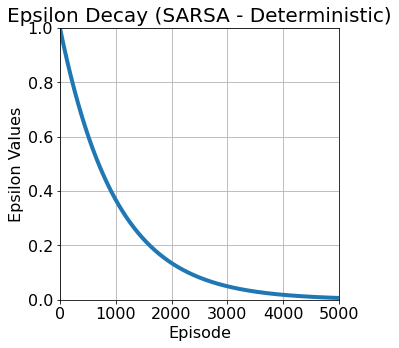

In [186]:
plt.figure(figsize=(5,5))
plt.plot(epsilon_sarsa_stoc, linewidth=4)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Epsilon Values', fontsize=16)
plt.title('Epsilon Decay (SARSA - Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()

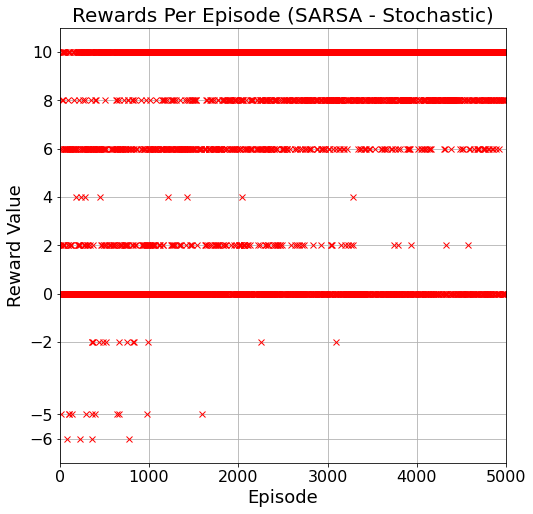

In [188]:
plt.figure(figsize=(8,8))
plt.plot(reward_sarsa_stoc, 'rx')
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Reward Value', fontsize=18)
plt.title('Rewards Per Episode (SARSA - Stochastic)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-6, -5, -2, 0, 2, 4, 6, 8, 10], fontsize=16)
plt.ylim(ymin=-7, ymax=11)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()